In [2]:
import time
import pickle
import torch
import copy
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from tqdm                   import tqdm
from torch.utils.data       import Dataset, DataLoader
from torch_geometric.loader import DataLoader as PyG_Dataloader

from config import PATH_SUMMARY_DATASETS

torch.manual_seed(42)
sns.set_theme(style="white")

Goals of this notebooks.
- [ ] Find out if the ln(ic50) values have significantly different distributions for the two datasets GDSC1 and GDSC2. If so, what can be done to combine both into a single dataset to get a larger training set?

# EDA

In [1]:
WITHOUT_MISSING_FOLDER = '/without_missing/'

In [4]:
# Reading the drug response matrix.
with open(f'{PATH_SUMMARY_DATASETS}{WITHOUT_MISSING_FOLDER}drug_response_matrix__gdsc2.pkl', 'rb') as f: 
    drm = pickle.load(f)  
print(drm.shape)
drm.head(3)

(91991, 5)


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50
3441054,22RV1,1003,Camptothecin,GDSC2,-3.142631
3459252,22RV1,1004,Vinblastine,GDSC2,-4.459259
3508920,22RV1,1006,Cytarabine,GDSC2,3.826935


In [6]:
# Save the GDSC table to a file.
gdsc_complete = pd.read_pickle(f'../../datasets/gdsc/my_datasets/gdsc_base.pkl')
print(gdsc_complete.shape)
gdsc_complete.head(5)


(446521, 14)


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,DRUG_NAME,RMSE,COSMIC_ID,POSITION
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,Erlotinib,0.022521,683665,14
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,Erlotinib,0.031840,684055,14
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,Erlotinib,0.026052,684057,14
45,1,ES7,0.972699,2371,2.692768,2.0,71,377574,GDSC1,0.088760,Erlotinib,0.110056,684059,14
54,1,EW-11,0.944462,2375,2.478678,2.0,231,638065,GDSC1,-0.111820,Erlotinib,0.087011,684062,14


In [8]:
gdsc1 = gdsc_complete[gdsc_complete.DATASET=='GDSC1']
gdsc2 = gdsc_complete[gdsc_complete.DATASET=='GDSC2']
print('GDSC1.shape', gdsc1.shape)
print('GDSC2.shape', gdsc2.shape)

GDSC1.shape (310946, 14)
GDSC2.shape (135575, 14)


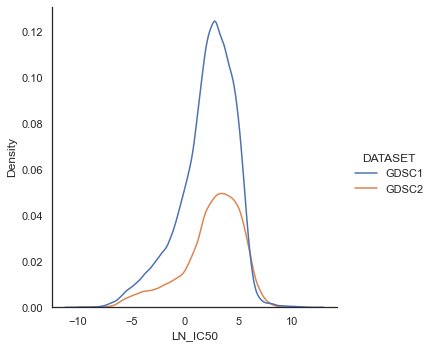

In [14]:
sns.displot(data=gdsc_complete, x='LN_IC50', hue='DATASET', kind='kde');

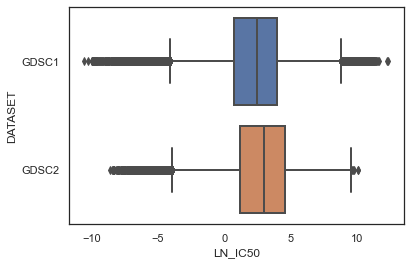

In [15]:
sns.boxplot(data=gdsc_complete, y='DATASET', x='LN_IC50', linewidth=2);

The distributions of ln(ic50) values seems not to differ significantly between the two datasets GDSC1 and GDSC2. 

Possible options:
1. probability [stability](https://en.wikipedia.org/wiki/Stability_(probability)) index ([PSI](https://medium.com/model-monitoring-psi/population-stability-index-psi-ab133b0a5d42)).

> Population Stability Index (PSI) compares the distribution of predicted probability in scoring data with predicted probability in training data. The idea is to check “How different the current scored data is, compared to the training data”.

2. Kolmogorov Smirnoff test

> _two-sample K–S test_: What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?

In [17]:
print(np.mean(gdsc1.LN_IC50.values))
print(np.mean(gdsc2.LN_IC50.values))

2.07394274914937
2.500906894427439


In [20]:
from scipy.stats import ks_2samp
ks_2samp(gdsc1.LN_IC50.values, gdsc2.LN_IC50.values)

KstestResult(statistic=0.09572259819709261, pvalue=0.0)

Since the p-value is much lower then 0.05, we can reject the null hypothesis. Thus, __we have evidence that the two sample datasets are not coming/drawn from the same distribution.__